<a href="https://colab.research.google.com/github/jainvaidic/hackerearth_mySolutions/blob/master/dance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q efficientnet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import efficientnet.tfkeras as efn
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/dance dataset/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/dance dataset/test.csv")
train_df

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi
...,...,...
359,72.jpg,manipuri
360,253.jpg,mohiniyattam
361,404.jpg,kuchipudi
362,89.jpg,manipuri


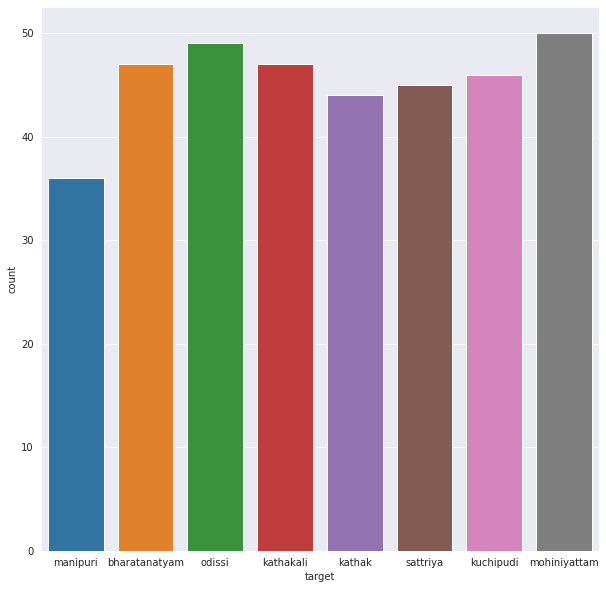

In [ ]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['target'])

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/dance dataset/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/dance dataset/test.csv")
train_df['Image'] = '/content/drive/My Drive/dance dataset/train/' + train_df['Image']
test_df['Image'] = '/content/drive/My Drive/dance dataset/test/' + test_df['Image']

train_df = train_df.replace('bharatanatyam', '0')
train_df = train_df.replace('kathak', '1')
train_df = train_df.replace('kathakali', '2')
train_df = train_df.replace('kuchipudi', '3')
train_df = train_df.replace('manipuri', '4')
train_df = train_df.replace('mohiniyattam', '5')
train_df = train_df.replace('odissi', '6')
train_df = train_df.replace('sattriya', '7')
val_df = train_df[0:32]
train_df = train_df[32:]
train_df

,Image,target
32,/content/drive/My Drive/dance dataset/train/17...,2
33,/content/drive/My Drive/dance dataset/train/34...,7
34,/content/drive/My Drive/dance dataset/train/16...,0
35,/content/drive/My Drive/dance dataset/train/2.jpg,1
36,/content/drive/My Drive/dance dataset/train/14...,0
...,...,...
359,/content/drive/My Drive/dance dataset/train/72...,4
360,/content/drive/My Drive/dance dataset/train/25...,5
361,/content/drive/My Drive/dance dataset/train/40...,3
362,/content/drive/My Drive/dance dataset/train/89...,4


In [ ]:
# from sklearn.preprocessing import LabelBinarizer
# label_binarizer = LabelBinarizer()
# y_train = train_df['target']
# y_train = label_binarizer.fit_transform(y_train)
# y_train[0:5,:]

In [ ]:
# train_imgs = []

# for index, row in train_df.iterrows():
    
#     train_img = image.load_img(row['Image'], target_size = (128,128,3))
#     train_img = image.img_to_array(train_img)
#     train_img = train_img / 225.0
#     train_imgs.append(train_img)
    
# train_imgs = np.array(train_imgs)


class Generators:
    """
    Train, validation and test generators
    """
    def __init__(self, train_df, val_df):
        self.batch_size=2
        self.img_size=(768,768)
        
        # Base train/validation generator
        train_datagen = ImageDataGenerator(
            rescale=1./255.,
            rotation_range=15,
            width_shift_range=0.15,
            height_shift_range=0.15,
            horizontal_flip=True
            )
        
        val_datagen = ImageDataGenerator(
            rescale=1./255.
            )
        # Train generator
        self.train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_df,
            x_col="Image",
            y_col="target",
            batch_size=self.batch_size,
#            seed=seed,
            shuffle=True,
            class_mode="categorical",
            target_size=self.img_size)
        print('Train generator created')
        # Validation generator
        self.val_generator = val_datagen.flow_from_dataframe(
            dataframe=val_df,
            x_col="Image",
            y_col="target",
            batch_size=self.batch_size,
#            seed=seed,
            shuffle=True,
            class_mode="categorical",
            target_size=self.img_size)    
        print('Validation generator created')
        
# Create generators        
generators = Generators(train_df, val_df)
print("Generators created")

Found 332 validated image filenames belonging to 8 classes.
Train generator created
Found 32 validated image filenames belonging to 8 classes.
Validation generator created
Generators created


In [ ]:
class ModelTrainer:
    """
    Create and fit the model
    """
    
    def __init__(self, generators):
        self.generators = generators
        self.img_width = generators.img_size[0]
        self.img_height = generators.img_size[1]
        
    def create_model(self):

      # model = Sequential()
      # model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (self.img_width, self.img_height,3)))
      # model.add(BatchNormalization())
      # model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
      # model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
      # model.add(Dropout(0.2))
      # model.add(BatchNormalization())
      # model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
      # model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
      # model.add(BatchNormalization())
      # model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
      # model.add(Flatten())
      # model.add(Dense(units = 512 , activation = 'relu'))
      # model.add(Dropout(0.3))
      # model.add(Dense(units = 8 , activation = 'softmax'))
      # model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

      # create the base pre-trained model

      base_model = efn.EfficientNetB1(weights='imagenet',input_shape=(self.img_width, self.img_height,3), include_top=False)
      # base_model = InceptionV3(weights='imagenet',input_shape=(self.img_width, self.img_height,3), include_top=False)

      # add a global spatial average pooling layer
      x = base_model.output
      x = GlobalAveragePooling2D()(x)
      # let's add a fully-connected layer
      x = Dense(64, activation='relu')(x)
      # and a logistic layer -- let's say we have 8 classes
      predictions = Dense(8, activation='softmax')(x)

      # this is the model we will train
      model = Model(inputs=base_model.input, outputs=predictions)

      # first: train only the top layers (which were randomly initialized)
      # i.e. freeze all convolutional InceptionV3 layers
      for layer in base_model.layers:
          layer.trainable = False

      # compile the model (should be done *after* setting layers to non-trainable)
      model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])
        
      # #model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
      return model
        
    
    def train(self, model):
        """
        Train the model
        """
        epochs=20
        steps_per_epoch=332 // 2
        validation_steps=32 // 2
            
        # # We'll stop training if no improvement after some epochs
        # earlystopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
        # reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
        #                            verbose=1, mode='max', min_lr=0.00001)

        # # Save the best model during the traning
        # checkpointer = ModelCheckpoint('best_model1.h5'
        #                                 ,monitor='val_acc'
        #                                 ,verbose=1
        #                                 ,save_best_only=True
        #                                 ,save_weights_only=True)
        
        # Train
        training = model.fit_generator(generator=self.generators.train_generator
                                ,epochs=epochs
                                ,steps_per_epoch=steps_per_epoch
                                ,validation_data=self.generators.val_generator
                                ,validation_steps=validation_steps)
#                                ,callbacks=[earlystopper, checkpointer, reduce_lr])
        # Get the best saved weights
        # model.load_weights('best_model1.h5')
        return training
    
# Create and train the model
trainer = ModelTrainer(generators)
model = trainer.create_model()

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 384, 384, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 384, 384, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 384, 384, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [ ]:
training=trainer.train(model)
print("Trained")

Epoch 1/20
166/166 [==============================] - 49s 294ms/step - loss: 1.6981 - accuracy: 0.3916 - val_loss: 1.5564 - val_accuracy: 0.4688
Epoch 2/20
166/166 [==============================] - 48s 288ms/step - loss: 1.0981 - accuracy: 0.6295 - val_loss: 1.3381 - val_accuracy: 0.6250
Epoch 3/20
166/166 [==============================] - 48s 291ms/step - loss: 0.8583 - accuracy: 0.7018 - val_loss: 1.5087 - val_accuracy: 0.4688
Epoch 4/20
166/166 [==============================] - 48s 289ms/step - loss: 0.7384 - accuracy: 0.7410 - val_loss: 1.1394 - val_accuracy: 0.6562
Epoch 5/20
166/166 [==============================] - 48s 288ms/step - loss: 0.6142 - accuracy: 0.8012 - val_loss: 1.3613 - val_accuracy: 0.5312
Epoch 6/20
166/166 [==============================] - 48s 289ms/step - loss: 0.5154 - accuracy: 0.8404 - val_loss: 1.0283 - val_accuracy: 0.6250
Epoch 7/20
166/166 [==============================] - 48s 289ms/step - loss: 0.4859 - accuracy: 0.8524 - val_loss: 1.0398 - val_ac

In [ ]:
test_imgs = []

for index, row in test_df.iterrows():
    test_img = image.load_img(row['Image'], target_size = (768,768,3))
    test_img = image.img_to_array(test_img)
    test_img = test_img / 225.0
    test_imgs.append(test_img)
    
test_imgs = np.array(test_imgs)

p = model.predict(test_imgs)
p = np.argmax(p, axis=1)

print(p)
p = p.reshape((np.shape(p)[0], 1))
# df_sub = pd.DataFrame()
# df_sub['Employee_ID'] = test['Employee_ID']
# df_sub['Attrition_rate'] = p

# df_sub.to_csv('submission.csv', index=False)

[3 5 3 3 0 3 0 2 7 3 5 0 7 7 3 3 6 1 5 0 3 2 2 6 5 2 6 3 3 0 5 3 1 3 5 2 6
 6 4 6 1 1 0 7 5 7 6 7 2 3 5 3 4 7 3 7 4 6 3 5 2 4 1 3 7 3 2 6 3 6 4 5 2 3
 6 2 1 5 2 1 5 1 3 6 6 5 7 1 4 2 4 1 1 3 6 0 7 2 3 3 6 0 1 6 1 3 2 3 4 6 1
 2 6 6 3 2 2 2 5 6 6 5 4 5 6 5 5 5 1 6 0 5 3 4 4 3 6 4 0 1 7 1 4 2 3 2 1 5
 4 3 5 7 2 3 6 7]


In [ ]:
df_sub = pd.DataFrame()
df_sub['Image'] = pd.read_csv("/content/drive/My Drive/dance dataset/test.csv")['Image']
df_sub['target'] = p

df_sub = df_sub.replace(0, 'bharatanatyam')
df_sub = df_sub.replace(1, 'kathak')
df_sub = df_sub.replace(2, 'kathakali')
df_sub = df_sub.replace(3, 'kuchipudi')
df_sub = df_sub.replace(4, 'manipuri')
df_sub = df_sub.replace(5, 'mohiniyattam')
df_sub = df_sub.replace(6, 'odissi')
df_sub = df_sub.replace(7, 'sattriya')
df_sub
df_sub.to_csv('/content/drive/My Drive/dance dataset/submission.csv', index=False)
#/content/drive/My Drive/dance dataset/train.csv







